# Self-Driving Car Engineer Nanodegree

## A Traffic Sign Recognition Classifier using Convolutional Neural Nets

Victor Roy

May 2, 2017

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle, time, os

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize


from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
from skimage.io import imread

from skimage.transform import warp, rotate, resize
from skimage.transform import AffineTransform
from skimage.exposure import adjust_gamma

In [2]:
# UTILITIES

# Load Data
def load_data(data_version, test = True):
    file_name = data_version+'.npz'
    if data_version == 'train':
        data = np.load('train.p')
        X = data['features']
        y = data['labels']
        return X,y
    elif data_version == 'valid':
        data = np.load('valid.p')
        X = data['features']
        y = data['labels']
        return X,y
    elif data_version == 'test':
        data = np.load('test.p')
        X = data['features']
        y = data['labels']
        return X,y
    else:
        if test == True:
            data = np.load(file_name)
            X = data['X']
            y = data['y']
            return X,y
        else:
            data = np.load(file_name)
            X = data['X']
            return X

        
def save_data(X, y=None, data_version = ''):
    if data_version.lower() == 'extended':
        file = 'extended.npz'
    elif data_version.lower() == 'processed':
        file = 'processed.npz'
    elif data_version != '':
        file = data_version+'.npz'
    else:
        raise(IOError('improper data_version argument'))
    if y:
        np.savez_compressed(file, X=X, y=y)
    else:
        np.savez_compressed(file, X=X)
    print('Data saved to {}'.format(file+'.npz'))
    return
    

---
## Step 0: Load The Data

In [3]:
X_train, y_train = load_data('train', test = True)
X_valid, y_valid = load_data('valid', test = True)
X_test, y_test = load_data('test', test = True)
signkey = pd.read_csv('signnames.csv', index_col = 0)

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [5]:
y_train_df = pd.Series(y_train)
value_counts = pd.DataFrame(y_train_df.value_counts(), columns = ['Count in Train'])
value_counts.sort_index(inplace = True)
signkey['Count in Train'] = value_counts['Count in Train']
del value_counts
signkey

,SignName,Count in Train
ClassId,,
0,Speed limit (20km/h),180
1,Speed limit (30km/h),1980
2,Speed limit (50km/h),2010
3,Speed limit (60km/h),1260
4,Speed limit (70km/h),1770
5,Speed limit (80km/h),1650
6,End of speed limit (80km/h),360
7,Speed limit (100km/h),1290
8,Speed limit (120km/h),1260


<function matplotlib.pyplot.show>

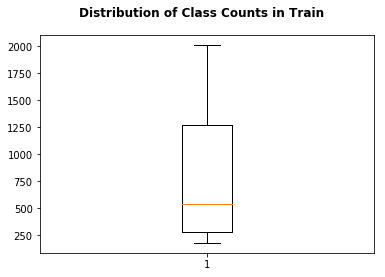

In [6]:
plt.boxplot(signkey['Count in Train'])
plt.suptitle('Distribution of Class Counts in Train', fontweight = 'bold')
plt.savefig('graphics/train-count_boxplot')
plt.show

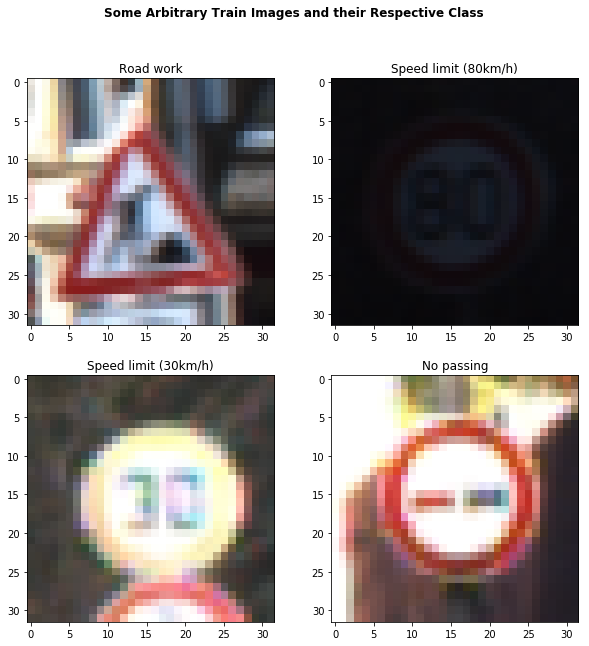

In [7]:
plt.close('all')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (10,10))
rand_index = np.random.choice(np.arange(n_train),4)
im1 = ax1.imshow(X_train[rand_index[0]])
ax1.set_title(signkey.loc[y_train[rand_index[0]],'SignName'])
im2 = ax2.imshow(X_train[rand_index[1]])
ax2.set_title(signkey.loc[y_train[rand_index[1]],'SignName'])
im3 = ax3.imshow(X_train[rand_index[2]])
ax3.set_title(signkey.loc[y_train[rand_index[2]],'SignName'])
im4 = ax4.imshow(X_train[rand_index[3]])
ax4.set_title(signkey.loc[y_train[rand_index[3]],'SignName'])

fig.suptitle('Some Arbitrary Train Images and their Respective Class', fontweight = 'bold')
plt.savefig('graphics/rand-images')

----

## Step 2: Design and Test a Model Architecture

### Data Augmentation & Preprocessing

In [8]:
# Methods for augmenting the data

# Randomly add a scale, rotation and brightness factor to each image
def extend_perturb(X, y):
    
    X_ext = np.ndarray([0, X.shape[1], X.shape[2], X.shape[3]])
    y_ext = np.ndarray([0])
    n_samples_og = X.shape[0]
    
    num_classes = 43
    start = time.time()
    
    for c in range(num_classes):
        X_c = np.ndarray([0, X.shape[1], X.shape[2], X.shape[3]])
            
        for img in X[y==c]:
            n = int(max([np.ceil(2000/signkey.loc[c,'Count in Train'])-1, 2]))
            for j in range(n):
                rotation_param = np.random.uniform(-np.pi/18., np.pi/18.)
                scale_param = np.random.uniform(.9, 1.1, 2)
                translation_param = tuple(np.random.choice(np.arange(-2,2), 2))
                gamma_param = np.random.uniform(.75, 1.25)


                tform = AffineTransform(rotation = rotation_param, translation =translation_param, scale = scale_param)
                img_warp = adjust_gamma(img_as_ubyte(warp(img, tform, mode = 'edge', preserve_range = False)), gamma = gamma_param).astype(np.uint8)
                
                X_c = np.append(X_c, [img_warp], axis = 0)
                y_ext = np.append(y_ext, [c], axis = 0)
        X_ext = np.append(X_ext, X_c, axis = 0)
            
        loop_time = time.time()-start
        n_samples_ext = X_ext.shape[0]
        print('{} classes completed; {} perturbed images added in {}s'.format(c+1, n_samples_ext, loop_time))
        
    X_ext = np.append(X, X_ext, axis = 0)
    y_ext = np.append(y, y_ext, axis = 0)
    
    return X_ext, y_ext
    
    
# Extend dataset by flipping images along their vertical and/or horizontal axes
def extend_flip(X, y):

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38],
    ])
    num_classes = 43

    X_ext = X
    y_ext = y
    
    for c in range(num_classes):
        c_size = X[y==c].shape[0]
        
        # if in self_flippable_horizontally
        if c in self_flippable_horizontally: 
            X_ext = np.append(X_ext, X[y==c][:,:,::-1, :], axis = 0)
            y_ext = np.append(y_ext, [c for i in np.ndarray([c_size])], axis = 0)

        # if in self_flippable_vertically
        if c in self_flippable_vertically:
            X_ext = np.append(X_ext, X[y==c][:,::-1,:, :], axis = 0)
            y_ext = np.append(y_ext, [c for i in np.ndarray([c_size])], axis = 0)

        # if in self_flippable_both
        if c in self_flippable_both:
            X_ext = np.append(X_ext, X[y==c][:,:,::-1, :][:,::-1,:, :], axis = 0)
            y_ext = np.append(y_ext, [c for i in np.ndarray([c_size])], axis = 0)

        # if in cross_flippable
        if c in cross_flippable[:,0]:
            c_prime = cross_flippable[np.argwhere(cross_flippable[:,0]==c)][0][0][1]
            X_ext = np.append(X_ext, X[y==c][:,:,::-1, :], axis = 0)
            y_ext = np.append(y_ext, [c_prime for i in np.ndarray([c_size])], axis = 0)
            
    return X_ext, y_ext


In [9]:
# Preprocessing the dataset.
# Different 'contrast modes' are possible; either: rescale_intensity, equalize_hist, or equalize_adapthist
def preprocessing(X, contrast_mode, grayscale = True, scale = True, batch_size = 5000):
    if grayscale:
        X_processed = np.ndarray([0, X.shape[1], X.shape[2], 1])
    else:
        X_processed = np.ndarray([0, X.shape[1], X.shape[2], X.shape[3]])
    
    batches = int(np.floor(X.shape[0]/batch_size)+1)
    
    start_time = time.time()
    for batch in range(batches):
        if grayscale:
            X_batch_processed = np.ndarray([0, X.shape[1], X.shape[2], 1])
        else:
            X_batch_processed = np.ndarray([0, X.shape[1], X.shape[2], X.shape[3]])
        start = batch*batch_size
        stop = start+batch_size
        X_slice = X[start:stop]
        for img in X_slice:
            if grayscale:
                img = img_as_ubyte(rgb2gray(img))
            if 'adapt' in contrast_mode:
                img = img_as_ubyte(equalize_adapthist(img.astype(np.uint8))).astype(np.uint8)
            elif 'equalize' in contrast_mode:
                img = img_as_ubyte(equalize_hist(img.astype(np.uint8))).astype(np.uint8)
            elif 'stretch' in contrast_mode:
                img = img_as_ubyte(rescale_intensity(img.astype(np.uint8))).astype(np.uint8)
            img = img.reshape(32, 32, 1)
            X_batch_processed = np.append(X_batch_processed, [img], axis = 0)

        X_processed = np.append(X_processed, X_batch_processed, axis = 0)
        loop = time.time()
        if X_processed.shape[0] >1000:
            print('{} images preprocessed in {}s'.format(min([X_batch_processed.shape[0],(batch+1)*batch_size]), loop-start_time))
    
    return X_processed
        
        

In [10]:
# Use equalize_adapthist method which tested better than equalize_hist or rescale_intensity
processing_mode = 'adapt'

In [11]:
# Data Processed separately using above methods and saved to numpy archive

data = np.load('processed_{}.npz'.format(processing_mode))
X_processed = data['X']
y_processed = data['y']
del data

data = np.load('valid_processed_{}.npz'.format(processing_mode))
X_valid_processed = data['X']
y_valid = data['y']
del data

data = np.load('test_processed_{}.npz'.format(processing_mode))
X_test_processed = data['X']
y_test = data['y']
del data

In [12]:
# Scale Data

X_processed = (X_processed-128)/128.
X_valid_processed = (X_valid_processed-128)/128.
X_test_processed = (X_test_processed-128)/128.

### Model Architecture

In [21]:
# Hyperparameters
# learning_rates tried: [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001]
# batch_sizes tried: [64, 128, 196, 256]

param_dict = {
        'learning_rate': 0.0005,
        'batch_size': 256,
        'epochs': 12
    }

In [22]:
# Architecture named as such in reference to LeCun & Sermanet
# on whose paper this architecture is partially derived

def LeSermaNet(x):    
    
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32; Output = 32x32@cnn_1_depth
    cnn_1_depth = 32
    cnn_1_fsize = 4
    cnn_1_W = tf.Variable(tf.random_normal([cnn_1_fsize, cnn_1_fsize, 1, cnn_1_depth], mean = mu, stddev = sigma))
    cnn_1_b = tf.Variable(tf.zeros([cnn_1_depth]))
    out_cnn_1 = tf.nn.conv2d(x, cnn_1_W, strides = [1,1,1,1], padding = 'SAME')
    out_cnn_1 = tf.nn.bias_add(out_cnn_1, cnn_1_b)
    # Activation.
    out_cnn_1 = tf.nn.elu(out_cnn_1)
    # Pooling. Input = 32x32@cnn_1_depth; Output = 16x16@cnn_1_depth
    out_pool_1 = tf.nn.max_pool(out_cnn_1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # For multi-layer passthrough; input = 16x16@cnn_1_depth; Ouput = 8x8@cnn_1_depth
    multi_layer_1 = flatten(tf.nn.max_pool(out_pool_1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME'))

    # Layer 2: Convolutional. Input = 16x16@cnn_1_depth; Output = 16x16@cnn_2_depth
    cnn_2_depth = 64
    cnn_2_fsize = 4
    cnn_2_W = tf.Variable(tf.random_normal([cnn_2_fsize, cnn_2_fsize, cnn_1_depth, cnn_2_depth], mean = mu, stddev = sigma))
    cnn_2_b = tf.Variable(tf.zeros([cnn_2_depth]))
    out_cnn_2 = tf.nn.conv2d(out_pool_1, cnn_2_W, strides = [1,1,1,1], padding = 'SAME')
    out_cnn_2 = tf.nn.bias_add(out_cnn_2, cnn_2_b)
    # Activation.
    out_cnn_2 = tf.nn.elu(out_cnn_2)
    # Pooling. Input = 16x16@cnn_2_depth, Output = 8x8@cnn_2_depth
    out_pool_2 = tf.nn.max_pool(out_cnn_2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # For multi-layer passthrough; input = 8x8@cnn_2_depth; Output = 4x4@cnn_2_depth
    multi_layer_2 = flatten(tf.nn.max_pool(out_pool_2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME'))
    
    # Layer 3: Convulutional. Input = 8X8@cnn_2_depth; Output = 8x8@cnn_3_depth
    cnn_3_depth = 128
    cnn_3_fsize = 4
    cnn_3_W = tf.Variable(tf.random_normal([cnn_3_fsize, cnn_3_fsize, cnn_2_depth, cnn_3_depth], mean = mu, stddev = sigma))
    cnn_3_b = tf.Variable(tf.zeros([cnn_3_depth]))
    out_cnn_3 = tf.nn.conv2d(out_pool_2, cnn_3_W, strides = [1,1,1,1], padding = 'SAME')
    out_cnn_3 = tf.nn.bias_add(out_cnn_3, cnn_3_b)
    # Activation
    out_cnn_3 = tf.nn.elu(out_cnn_3)
    # Pooling. Input = 8x8@cnn_3_depth, Output = 4x4@cnn_3_depth
    out_pool_3 = tf.nn.max_pool(out_cnn_3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    
    # Flatten. Input = 4x4xcnn_3_depth,
    out_pool_3 = flatten(out_pool_3)
    
    # Concat all passthrough tensor with flattened out_pool_3 
    #in_full_1 = tf.concat([flattened, multi_layer_1, multi_layer_2], axis = 1)
    in_full_1 = tf.concat(values = [out_pool_3, multi_layer_1, multi_layer_2], concat_dim = 1)
    in_full_depth = int((4*4*cnn_3_depth) + (4*4*cnn_2_depth)+ (8*8*cnn_1_depth))
    
    # Fully Connected. 
    full_1_depth = int(in_full_depth/4)
    full_1_W = tf.Variable(tf.truncated_normal(shape = [in_full_depth, full_1_depth], mean = mu, stddev = sigma))
    full_1_b = tf.Variable(tf.zeros([full_1_depth]))
    out_full_1 = tf.add(tf.matmul(in_full_1, full_1_W), full_1_b)
    
    # Activation
    keep_prob_1 = 0.5
    out_full_1 = tf.nn.elu(out_full_1)
    out_full_1 = tf.nn.dropout(out_full_1, keep_prob = keep_prob_1)

    # TODO: Layer 4: Fully Connected. Output = 84.
    full_2_depth = 256
    
    full_2_W = tf.Variable(tf.truncated_normal(shape = [full_1_depth, full_2_depth], mean = mu, stddev = sigma))
    full_2_b = tf.Variable(tf.zeros([full_2_depth]))
    out_full_2 = tf.add(tf.matmul(out_full_1, full_2_W), full_2_b)
    
    # TODO: Activation
    keep_prob_2 = 0.75
    out_full_2 = tf.nn.elu(out_full_2)
    out_full_2 = tf.nn.dropout(out_full_2, keep_prob = keep_prob_2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    out_W = tf.Variable(tf.truncated_normal(shape = [full_2_depth, 43], mean = mu, stddev = sigma))
    out_b = tf.Variable(tf.zeros(shape = 43))
    logits = tf.add(tf.matmul(out_full_2, out_W),out_b)
    
    return logits

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [24]:
rate = param_dict['learning_rate']

logits = LeSermaNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.MomentumOptimizer(learning_rate = rate, momentum = 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
EPOCHS = param_dict['epochs']
BATCH_SIZE = param_dict['batch_size']

with tf.Session() as sess:
    time_start = time.time()
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    epoch_scores = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #X_train, y_train = shuffle(X_train, y_train)
        X_train, y_train = shuffle(X_processed, y_processed)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        time_epoch = time.time()
        #validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_processed, y_processed)
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        epoch_scores.append(validation_accuracy)
        print("Epoch {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("{} Epochs in {:.2f}m @ {:.1f}m/epoch".format(i+1, (time_epoch-time_start)/60., ((time_epoch-time_start)/60.)/(i+1)))
        print()
    
    save_path = saver.save(sess, './lesermanet')
    saver.save(sess, './lesermanet')
    print("Model saved to %s" % save_path)

Training...

Epoch 1 ...
Training Accuracy = 0.786
Validation Accuracy = 0.782
1 Epochs in 4.57m @ 4.6m/epoch

Epoch 2 ...
Training Accuracy = 0.913
Validation Accuracy = 0.913
2 Epochs in 10.62m @ 5.3m/epoch

Epoch 3 ...
Training Accuracy = 0.952
Validation Accuracy = 0.942
3 Epochs in 16.47m @ 5.5m/epoch

Epoch 4 ...
Training Accuracy = 0.969
Validation Accuracy = 0.946
4 Epochs in 22.48m @ 5.6m/epoch

Epoch 5 ...
Training Accuracy = 0.978
Validation Accuracy = 0.965
5 Epochs in 28.47m @ 5.7m/epoch

Epoch 6 ...
Training Accuracy = 0.981
Validation Accuracy = 0.963
6 Epochs in 34.97m @ 5.8m/epoch

Epoch 7 ...
Training Accuracy = 0.986
Validation Accuracy = 0.966
7 Epochs in 41.89m @ 6.0m/epoch

Epoch 8 ...
Training Accuracy = 0.985
Validation Accuracy = 0.960
8 Epochs in 49.29m @ 6.2m/epoch

Epoch 9 ...
Training Accuracy = 0.987
Validation Accuracy = 0.968
9 Epochs in 57.49m @ 6.4m/epoch

Epoch 10 ...
Training Accuracy = 0.990
Validation Accuracy = 0.971
10 Epochs in 66.08m @ 6.6m/epo

## Evaluation

In [27]:
with tf.Session() as sess:
    saver.restore(sess, './lesermanet')

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.945


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [28]:
### Load the images and plot them here.

def load_images():
    custom_images = np.ndarray([0, 32, 32, 3])
    for i in range(1,6):
        img = imread('german_roadsigns/test_sign_{}'.format(i))
        img = img[:,:,:3]
        img = resize(img, (32,32))
        custom_images = np.append(custom_images, [img], axis = 0)
    return custom_images

X_custom = load_images()
y_custom = np.array([18, 38, 12, 17, 1])

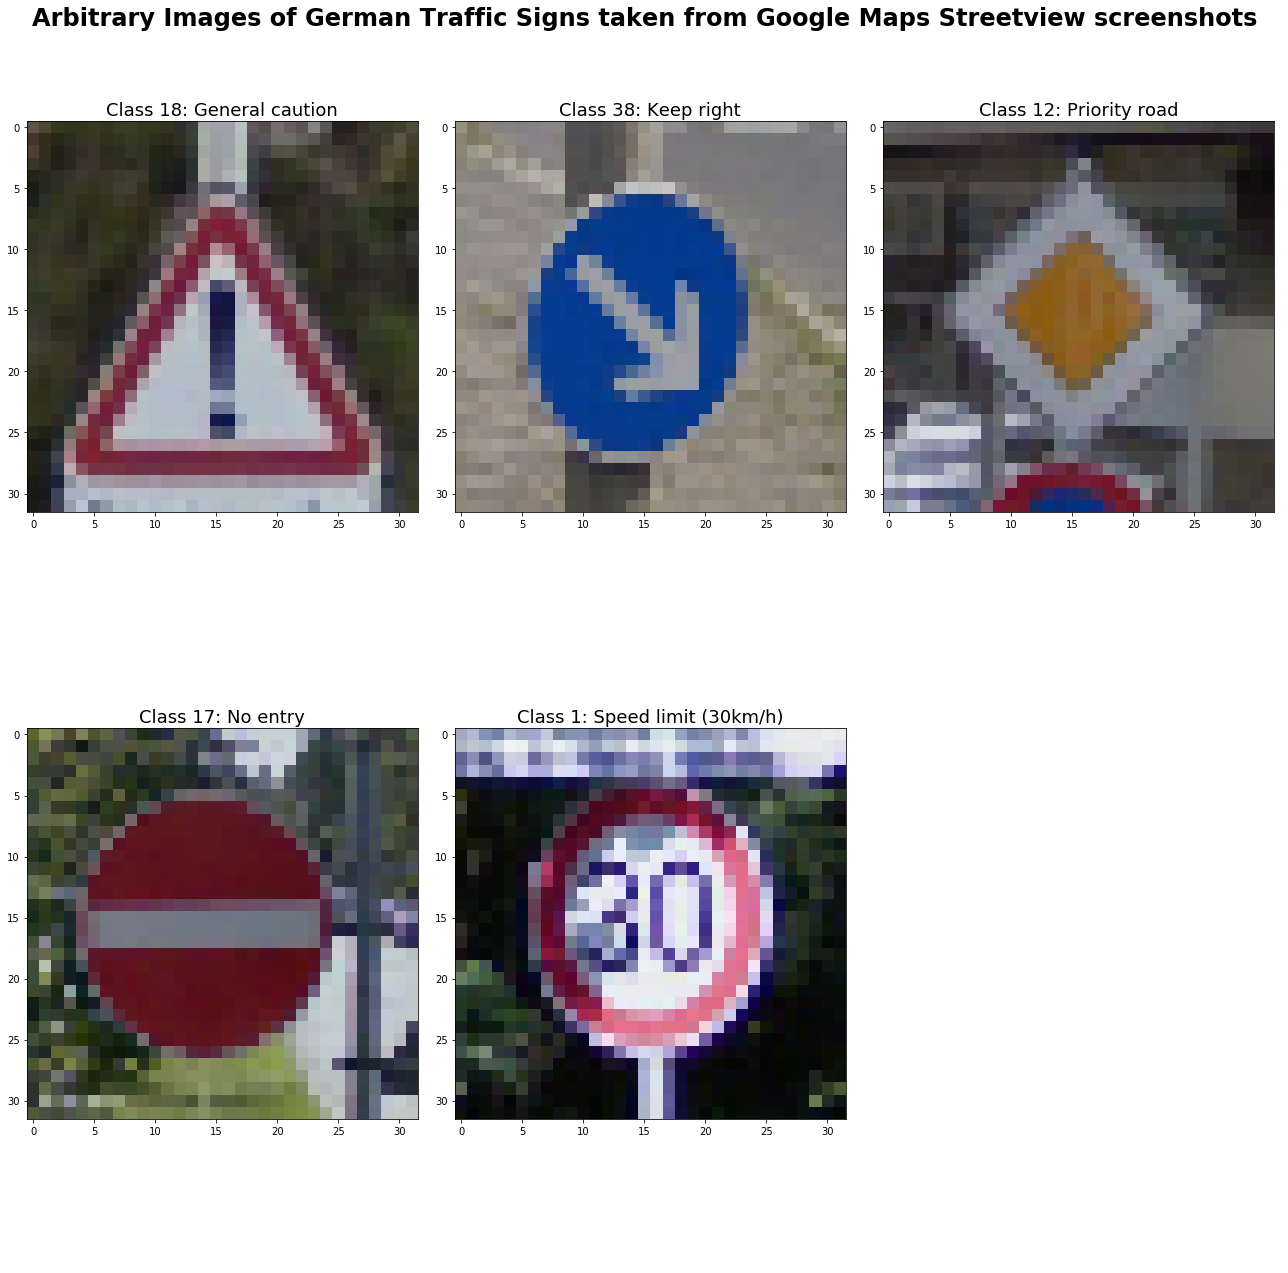

In [29]:
fig, ((ax1,ax2,ax3),(ax4,ax5, ax6)) = plt.subplots(2,3, figsize = (18,18))
fig.suptitle('Arbitrary Images of German Traffic Signs taken from Google Maps Streetview screenshots', fontsize = 24, fontweight = 'bold')
im1 = ax1.imshow(X_custom[0])
ax1.set_title('Class {}: {}'.format(y_custom[0], signkey.loc[y_custom[0], 'SignName']), fontsize = 18)
im2 = ax2.imshow(X_custom[1])
ax2.set_title('Class {}: {}'.format(y_custom[1], signkey.loc[y_custom[1], 'SignName']), fontsize = 18)
im3 = ax3.imshow(X_custom[2])
ax3.set_title('Class {}: {}'.format(y_custom[2], signkey.loc[y_custom[2], 'SignName']), fontsize = 18)
im4 = ax4.imshow(X_custom[3])
ax4.set_title('Class {}: {}'.format(y_custom[3], signkey.loc[y_custom[3], 'SignName']), fontsize = 18)
im5 = ax5.imshow(X_custom[4])
ax5.set_title('Class {}: {}'.format(y_custom[4], signkey.loc[y_custom[4], 'SignName']), fontsize = 18)
ax6.axis('off')

plt.tight_layout()
plt.savefig('graphics/custom_roadsigns')



### Predict the Sign Type for Each Image

In [30]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_custom_processed = preprocessing(X_custom, contrast_mode = 'adapt', scale = False)
X_custom_processed = (X_custom_processed-128)/128


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


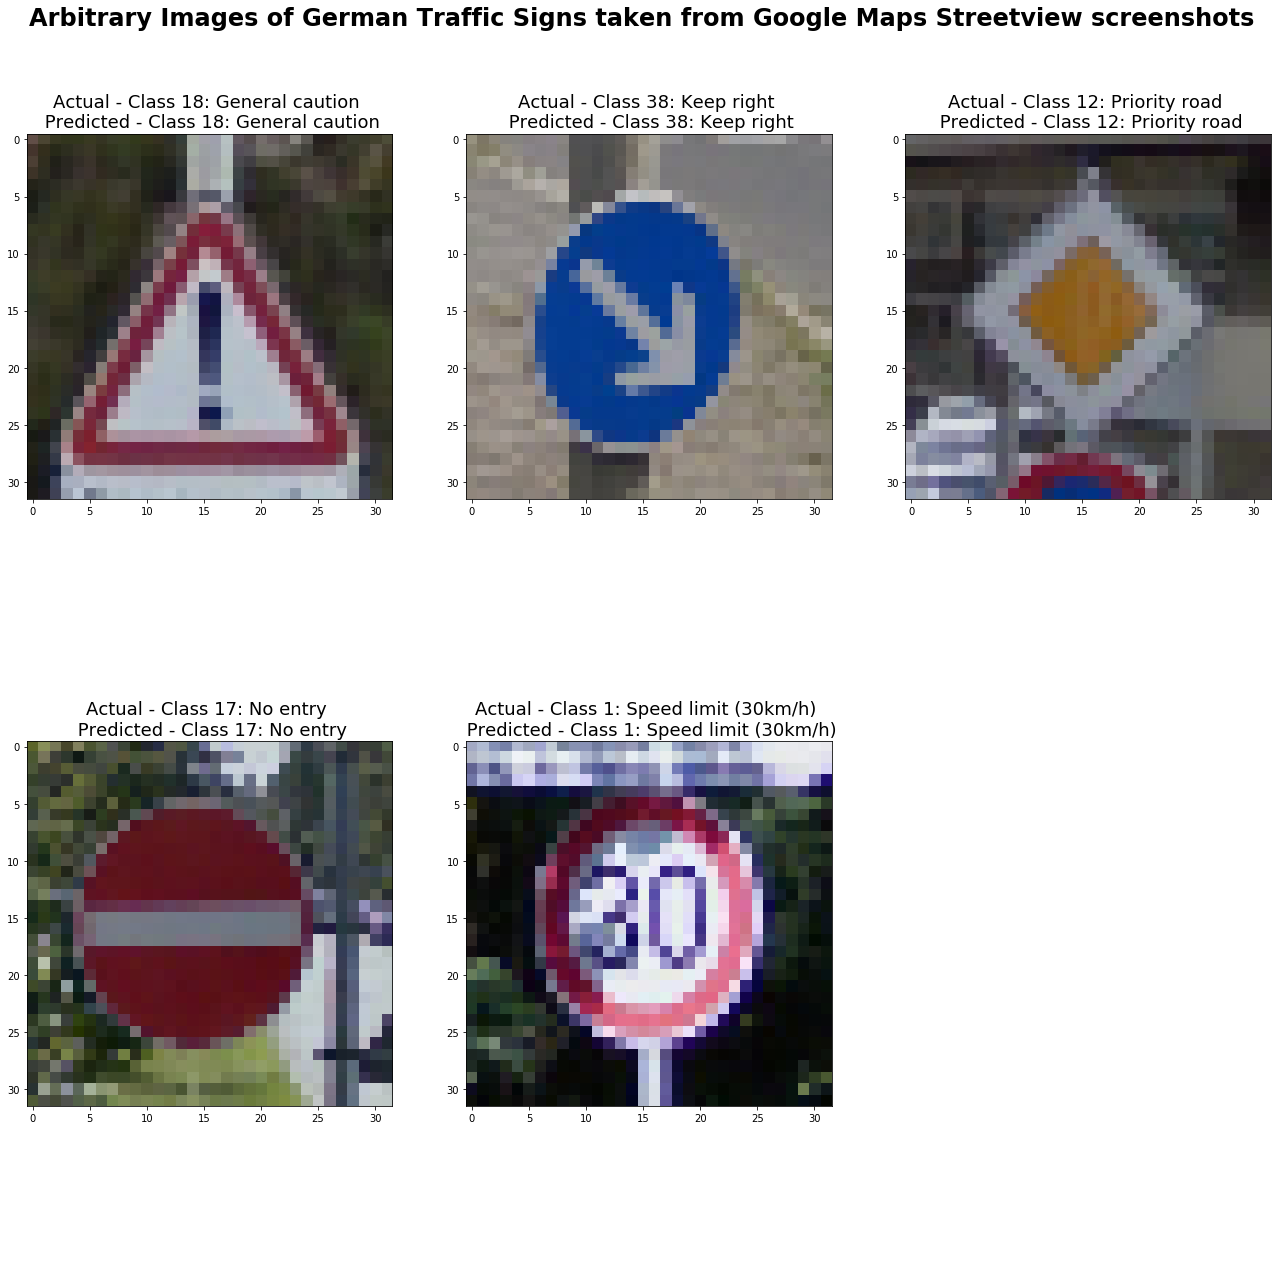

In [31]:
with tf.Session() as sess:
    saver.restore(sess, './lesermanet')

    logits_custom = sess.run(logits, feed_dict = {x: X_custom_processed, y: y_custom})

y_hat_custom = np.argmax(logits_custom, axis = 1)

fig, ((ax1,ax2,ax3),(ax4,ax5, ax6)) = plt.subplots(2,3, figsize = (18,18))
fig.suptitle('Arbitrary Images of German Traffic Signs taken from Google Maps Streetview screenshots', fontsize = 24, fontweight = 'bold')
im1 = ax1.imshow(X_custom[0])
ax1.set_title('Actual - Class {}: {} \n Predicted - Class {}: {}'.format(y_custom[0], signkey.loc[y_custom[0], 'SignName'], y_hat_custom[0], signkey.loc[y_hat_custom[0], 'SignName']), fontsize = 18)
im2 = ax2.imshow(X_custom[1])
ax2.set_title('Actual - Class {}: {} \n Predicted - Class {}: {}'.format(y_custom[1], signkey.loc[y_custom[1], 'SignName'], y_hat_custom[1], signkey.loc[y_hat_custom[1], 'SignName']), fontsize = 18)
im3 = ax3.imshow(X_custom[2])
ax3.set_title('Actual - Class {}: {} \n Predicted - Class {}: {}'.format(y_custom[2], signkey.loc[y_custom[2], 'SignName'], y_hat_custom[2], signkey.loc[y_hat_custom[2], 'SignName']), fontsize = 18)
im4 = ax4.imshow(X_custom[3])
ax4.set_title('Actual - Class {}: {} \n Predicted - Class {}: {}'.format(y_custom[3], signkey.loc[y_custom[3], 'SignName'], y_hat_custom[3], signkey.loc[y_hat_custom[3], 'SignName']), fontsize = 18)
im5 = ax5.imshow(X_custom[4])
ax5.set_title('Actual - Class {}: {} \n Predicted - Class {}: {}'.format(y_custom[4], signkey.loc[y_custom[4], 'SignName'], y_hat_custom[4], signkey.loc[y_hat_custom[4], 'SignName']), fontsize = 18)
ax6.axis('off')

plt.tight_layout()
plt.savefig('graphics/custom_roadsigns_predictions')


### Analyze Performance

In [32]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

accuracy_custom = np.mean([x==y for (x,y) in zip(y_custom, y_hat_custom)])

print('Accuracy for custom images is {:.1%}'.format(accuracy_custom))

Accuracy for custom images is 100.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [33]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

def softmax(logits):
    softmax_probs = np.nan_to_num(np.exp(logits))
    softmax_probs = softmax_probs/np.nan_to_num(np.sum(np.exp(logits), axis = 1, keepdims = True))
    return softmax_probs
    
softmax_probs = softmax(logits_custom)

with tf.Session() as sess:
    top_5_probs = sess.run(tf.nn.top_k(tf.constant(softmax_probs), k=5))
    
    
from pandas.tools.plotting import table


plt.savefig('mytable.png')
for i in range(top_5_probs[0].shape[0]):
    custom_prob_dict = {'Probability': top_5_probs[0][i], 'Class':top_5_probs[1][i].astype(np.uint8)}
    custom_i_df = pd.DataFrame(custom_prob_dict)
    custom_i_df = custom_i_df.round(4)
    custom_i_df.index = list(signkey.loc[list(custom_i_df.loc[:,'Class']), 'SignName'])
    print('Actual Class for Sign - {}: {}'.format(y_custom[i], signkey.loc[y_custom[i], 'SignName']))
    print(custom_i_df)
    print('\n')
    
    '''
    ax = plt.subplot(111, frame_on=False) # no visible frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    title_string = 'Softmax Probabilities for Streetview Signs, Actual Class - {}: {}'.format(y_custom[i], signkey.loc[y_custom[i], 'SignName'])
    ax.set_title(title_string)
    table(ax, custom_i_df)  # where df is your data frame
    '''
    
    ax  = custom_i_df.plot(kind = 'bar')
    fig = ax.get_figure()
    plt.tight_layout()
    plt.savefig('graphics/softmax_probs_{}'.format(i))
    plt.close('all')

    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


Actual Class for Sign - 18: General caution
                 Class  Probability
General caution     18          1.0
Pedestrians         27          0.0
Traffic signals     26          0.0
No entry            17          0.0
Double curve        21          0.0


Actual Class for Sign - 38: Keep right
                      Class  Probability
Keep right               38          1.0
No entry                 17          0.0
Priority road            12          0.0
Turn left ahead          34          0.0
Roundabout mandatory     40          0.0


Actual Class for Sign - 12: Priority road
                      Class  Probability
Priority road            12          1.0
Yield                    13          0.0
Roundabout mandatory     40          0.0
No entry                 17          0.0
Keep left                39          0.0


Actual Class for Sign - 17: No entry
                                          Class  Probability
No entry                                     17          1.0
Ve

### ** END**